## Reflection 

성찰은 창작 프롬프트와 수정 프롬프트 사이의 반복적인 과정을 통해 형성된다. 이 과정은 인간이 창조하는 과정을 모방한 결과이다. 

### 인간의 사고방식

- 시스템1(반응적/본능적): 빠르지만 무의식적이고 일상적인 결정을 하여 오류가 발생하기 쉬움
- 시스템2(체계적/성찰적): 느리지만 의식적이고 노력에 따른 복잡한 결정을 하려 신뢰할 수 있음 

- 예시
    - `generate 노드`: 에시이 초안에 작성하거나 개정
    - `reflect 노드`: 이후 수정에 반영할 비평 작성 

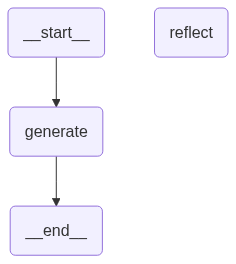

In [ ]:
import ast 
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages # reducer function

model = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature = 0.1)

# 상태 타입 정의 
class State(TypedDict):
    messages: Annotated[list, add_messages]

generate_prompt = SystemMessage(
    '당신은 훌륭한 3단락 에세이를 작성하는 임무를 가진 에세이 어시스턴트입니다.'
    '사용자의 요청에 맞춰 최상의 에세이를 작성하세요'
    '사용자가 비평을 제공하면, 이전 시도에 대한 수정 버전을 응답하시오'
)

# feedback 노드 
reflection_prompt = SystemMessage(
    '당신은 에세이 제출물을 평가하는 교사입니다. 사용자의 제출물에 대해 비평과 추천을 생성하세요'
    '길이, 깊이, 스타일 등과 같은 구체적인 요구사항을 포함한 자세한 추천을 제공하세요'
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state['messages'])
    return {'messages': [answer]}

def reflect(state: State) -> State:
    # 메세지를 반전시켜서 LLM이 자신의 출력을 성찰하도록 설정 
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    
    # 첫 번째 메시지는 원래 사용자의 요청, 모든 노드에서 동일하게 유지해야됨 
    translated = [reflection_prompt, state['messages'][0]] + [
        cls_map[msg.__class__](content = msg.content) for msg in state['messages'][1:]
    ]
    
    answer = model.invoke(translated)
    
    return {"messages": [HumanMessage(content = answer.content)]}

# 길이 제한을 통해 reflect와 generate의 균형 설정 
def should_continue(state: State) -> State:
    if len(state['messages']) > 6:
        return END
    else:
        return 'reflect'

builder = StateGraph(State)
builder.add_node('generate', generate)
builder.add_node('reflect', reflect) # ToolNode 자체적으로 예외를 처리 
builder.add_edge(START, 'generate')
# 최신 AI Messages에서 사용된 Tools를 확인해보고 존재하면 tools 노드로 연결하는 조건부 엣지 함수 
builder.add_conditional_edges('generate', should_continue) 
builder.add_edge('reflect', 'generate') # 성찰한 후 다시 응답 생성 

graph = builder.compile()
graph

## Subgraphs

서브 그래프는 다른 그래프의 일부로 들어가는 하위 그래프를 의미하며, 랭그래프를 활용하여 다중 에이전트 아키텍처를 실현하는 핵심 기술 개념이다. 

- 멀티 에이전트 시스템을 구축
- 여러 그래프에서 동일한 노드 집합을 사용하는 경우, 해당 노드를 서브그래프에 정의한 후 그래프에 활용

### 부모 그래프에 서브그래프 노드를 추가하는 방법
- 서브그래프를 직접 호출하는 노드를 추가: 부모와 서브가 상태키를 공유할 경우에 사용하기 좋으며, 상태를 입출력할 때 별도의 변환 과정을 거칠 필요 없이 그대로 활용 가능하다. 

- 서브그래프를 호출하는 함수를 포함한 노드를 추가: 부모와 서브가 서로 다른 상태 키를 사용할 때 좋음

### 서브그래프 직접 호출 

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import START, StateGraph

# 부모 그래프와 서브그래프에서 사용할 상태 
class State(TypedDict):
     foo: str # 서브 그래프와 이 상태 키를 공유 
     
class SubgraphState(TypedDict):
    foo: str # 부모 그래프와 이 키를 공유 
    bar: str 

def subgraph_node(state: SubgraphState):
    return {'foo': state['foo'] + 'bar'}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node('subgraph_node', subgraph_node)
subgraph_builder.add_edge(START, "subgraph_node")
subgraph = subgraph_builder.compile()

builder = StateGraph(State)
builder.add_node("subgraph", subgraph)
builder.add_edge(START, 'subgraph')
graph = builder.compile()

initial_state = {'foo':'hello'}
result = graph.invoke(initial_state)
print(f"Result: {result}") # foo에 bar가 추가되어야됨 

Result: {'foo': 'hellobar'}
